In [74]:
!pip install --user uproot
!pip install --user tqdm
!pip install awkward
!pip install xgboost
!pip install sklearn

In [75]:
import uproot
import glob
import pandas as pd
from tqdm import tqdm
import numpy as np
import awkward as ak
import ROOT

In [76]:
root_files = glob.glob("/home/pku/anying/cms/PKU-Cluster/WWg/BDT/rootfiles/optimal*.root")

In [77]:
root_files

['/home/pku/anying/cms/PKU-Cluster/WWg/BDT/rootfiles/optimal_emua_ST16.root',
 '/home/pku/anying/cms/PKU-Cluster/WWg/BDT/rootfiles/optimal_emua_ST17.root',
 '/home/pku/anying/cms/PKU-Cluster/WWg/BDT/rootfiles/optimal_emua_ST18.root',
 '/home/pku/anying/cms/PKU-Cluster/WWg/BDT/rootfiles/optimal_emua_ST_pre16.root',
 '/home/pku/anying/cms/PKU-Cluster/WWg/BDT/rootfiles/optimal_emua_TTGJets16.root',
 '/home/pku/anying/cms/PKU-Cluster/WWg/BDT/rootfiles/optimal_emua_TTGJets17.root',
 '/home/pku/anying/cms/PKU-Cluster/WWg/BDT/rootfiles/optimal_emua_TTGJets18.root',
 '/home/pku/anying/cms/PKU-Cluster/WWg/BDT/rootfiles/optimal_emua_TTGJets_pre16.root',
 '/home/pku/anying/cms/PKU-Cluster/WWg/BDT/rootfiles/optimal_emua_VV16.root',
 '/home/pku/anying/cms/PKU-Cluster/WWg/BDT/rootfiles/optimal_emua_VV17.root',
 '/home/pku/anying/cms/PKU-Cluster/WWg/BDT/rootfiles/optimal_emua_VV18.root',
 '/home/pku/anying/cms/PKU-Cluster/WWg/BDT/rootfiles/optimal_emua_VV_pre16.root',
 '/home/pku/anying/cms/PKU-Clust

In [78]:
f1 = uproot.open(root_files[0])
tree=f1['outtree']

In [79]:
branch=tree.keys()
unneccesary_columns = ['LHEScaleWeight','LHEPdfWeight']
for c in unneccesary_columns:
    branch.remove(c)
len(branch)

115

In [80]:
f = uproot.lazy(root_files[0]+':outtree')
events = ak.to_pandas(f[branch])
len(f)

72

In [81]:
def get_df(root_file_name):
    if 'Muon' not in root_file_name and 'Ele' not in root_file_name:
        f = uproot.lazy(root_file_name+":outtree")
        if len(f) == 0:
            return pd.DataFrame()
        df = ak.to_pandas(f[branch])
    else:
        return pd.DataFrame()
    return df  

In [82]:
df = pd.concat((get_df(f) for f in tqdm(root_files)), ignore_index=True)

100%|███████████████████████████████████████████| 36/36 [00:11<00:00,  3.07it/s]


In [83]:
df.shape

(18461, 115)

In [84]:
features=['lep1pt','lep2pt','lep1eta','lep2eta','lep1phi','lep2phi','drll','ptll','yVlep','phiVlep','mll','mT','mT2','PuppiMET_T1Smear_pt','PuppiMET_T1Smear_phi','photonet','photoneta','drl1a','drl2a','ml1g','ml2g','mllg']
#features=['lep1pt','lep2pt','lep1eta','lep2eta','lep1phi','lep2phi','drll','ptll','yVlep','phiVlep','mll','mT','mT2','PuppiMET_T1Smear_pt','PuppiMET_T1Smear_phi','photonet','photoneta','drl1a','drl2a','n_bjets20_medium']

In [85]:
from sklearn.model_selection import train_test_split
import xgboost as xgb
n_boost_rounds = 10
xgboost_params = {'eval_metric':'auc',
                 # 'max_depth' : 4,
                  'objective'  :'binary:logitraw'}

In [15]:
category=['0jets','1jets']

In [121]:
#for i,group_df in df.groupby("njets30"):
#    print(i,'',group_df['njets30'])
    
X=group_df[features]
Y=group_df['isSignal']
    
    #random_state is the seed used by the random number generator, 
    #random_state=42 make others get the same data spliting in different executions.
    # shuffle make the bkg and signal mix randomly.
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.4, 
                                                        random_state=42,shuffle=True)
idx_train = X_train.index
idx_test = X_test.index
    
    # XGBoost has it's own data format, so we have to create these structures. 
    #(The copies have no specific purpose other than silencing an xgboost warning.)

dmatrix_train = xgb.DMatrix(X_train.copy(), label=np.copy(y_train))
dmatrix_test  = xgb.DMatrix(X_test.copy(), label=np.copy(y_test ))

n_pos = np.sum(y_train == 1)
n_neg = np.sum(y_train == 0)

print('number of bkg ',n_neg,' number of sig ',n_pos)
    # There is one additional hyperparameter needed to set per catoegy: `scale_pos_weight`.
    # It corresponds  to a weight given to every positive sample, and it usually set to
    # n_neg / n_pos when you have imbalanced datasets to balance the total contributions
    # of the positive and negative classes in the loss function
    
xgboost_params["scale_pos_weight"] = 1. * n_neg / n_pos
    
    # Train
model = xgb.train(xgboost_params,
                      dmatrix_train,
                      num_boost_round=n_boost_rounds,
                      evals= [(dmatrix_train, 'train'),
                              (dmatrix_test, 'test')],
                      early_stopping_rounds=10,
                      verbose_eval=False)
    
best_iteration = model.best_iteration + 1
if best_iteration < n_boost_rounds:
        print("early stopping after {0} boosting rounds".format(best_iteration))
print("")
    
model.save_model('model.json')
 
    # Add new column for the BDT output
df.loc[idx_train, "score"] = model.predict(dmatrix_train)
df.loc[idx_test, "score"] = model.predict(dmatrix_test)
    
    # Add new column to separate the test and train
df.loc[idx_train, "test"] = False
df.loc[idx_test, "test"] = True

number of bkg  1360  number of sig  4625



In [124]:
import matplotlib.pyplot as plt
from sklearn import metrics

def plot_roc_curve(df, score_column, tpr_threshold=0.7, ax=None, color=None, linestyle='-', label=None):
    if ax is None:
        ax = plt.gca()
    if label is None:
        label = score_column
    fpr, tpr, thresholds = metrics.roc_curve(df['isSignal'], df[score_column])
    mask = tpr > tpr_threshold
    fpr, tpr = fpr[mask], tpr[mask]
    ax.semilogy(tpr, fpr, label=label, color=color, linestyle=linestyle)

In [125]:
fpr, tpr, thresholds = metrics.roc_curve(df['isSignal'], df['score'])

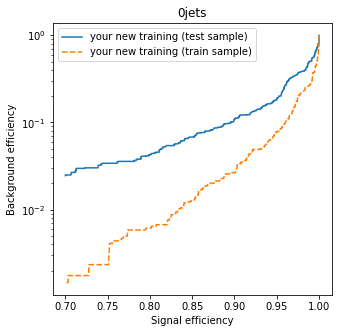

In [131]:
fig, axes = plt.subplots(1, 1, figsize=(5,5))
if True:
    
    df_train = df.query('test==False')
    df_test =  df.query("test==True")
    
    ax=axes
    ax.set_xlabel("Signal efficiency")
    ax.set_ylabel("Background efficiency")
    #plot_roc_curve(df_test, "lep1pt", ax=ax)
    plot_roc_curve(df_test, "score", ax=ax, label="your new training (test sample)")
    plot_roc_curve(df_train, "score", ax=ax, color="#ff7f02", linestyle='--', label="your new training (train sample)")
    ax.set_title(category[i])
    ax.legend()

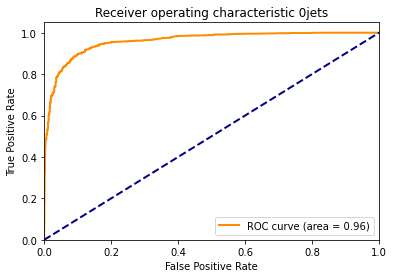

In [132]:
from sklearn.metrics import roc_curve, auc
if True:
    
    df_train = df.query('test==False')
    df_test =  df.query("test==True")

    fpr, tpr, _ = roc_curve(df_test['isSignal'], df_test['score'])
    roc_auc = auc(fpr, tpr)
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic '+category[i])
    plt.legend(loc="lower right")

In [133]:
model=xgb.Booster()
model.load_model('./model.json')

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

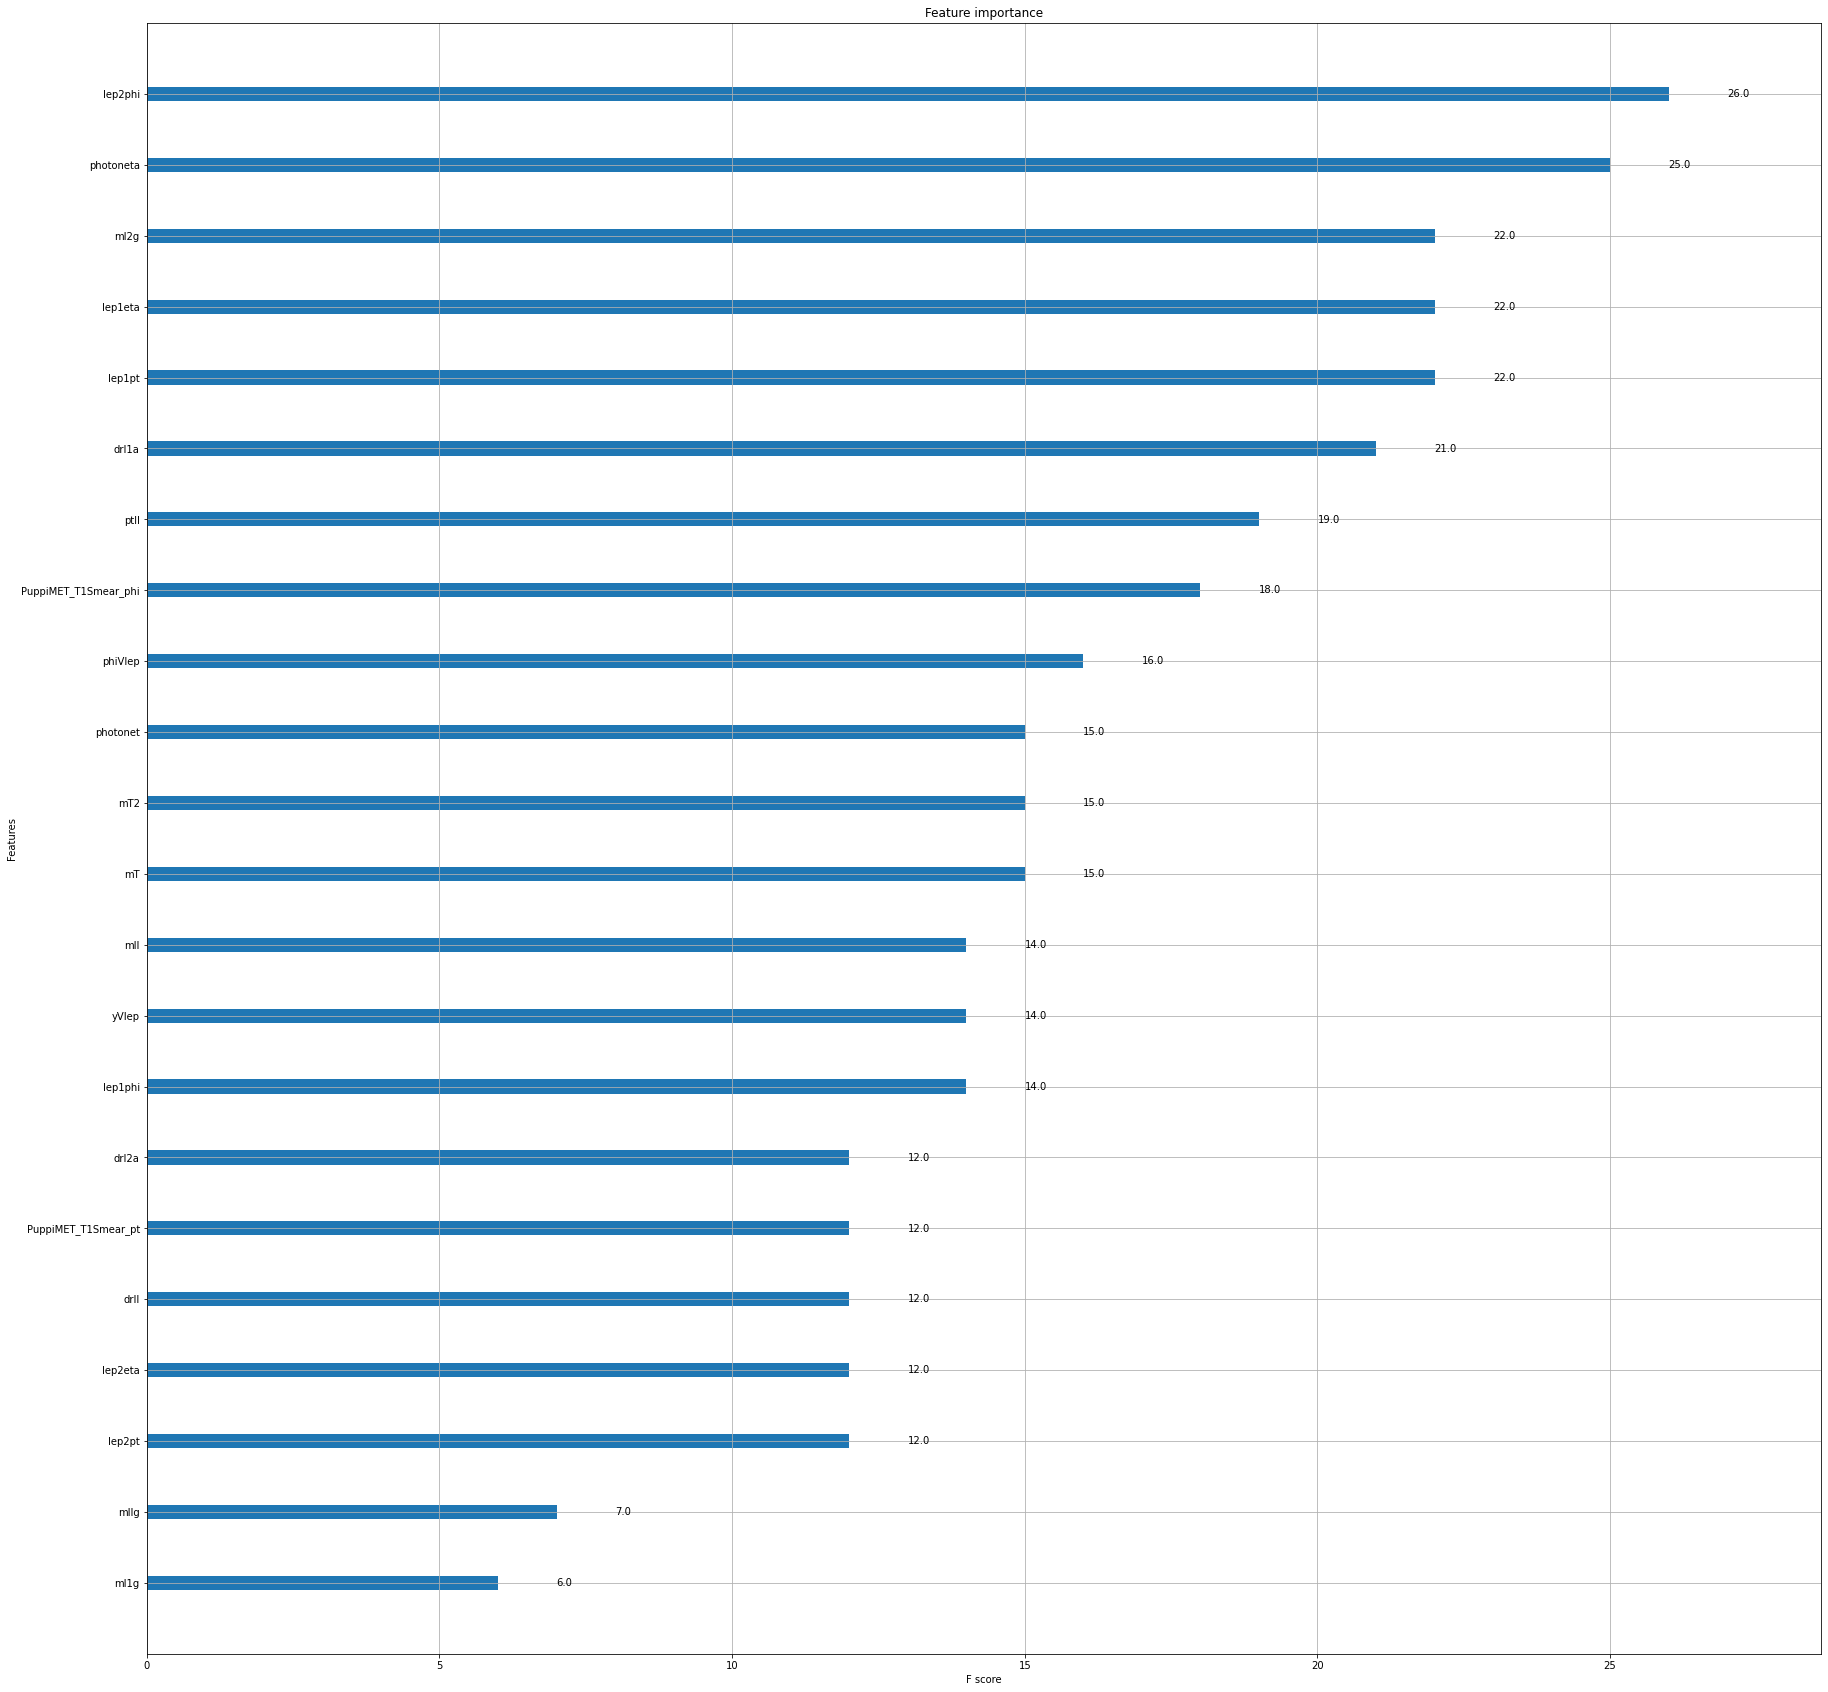

In [134]:
from xgboost import plot_importance
plt.figure(figsize = (30,30))
ax = plt.subplot(111)

plot_importance(model,ax=ax)

In [135]:
root_files18 = glob.glob("/home/pku/anying/cms/PKU-Cluster/WWg/BDT/rootfiles/optimal*18.root")
root_files17 = glob.glob("/home/pku/anying/cms/PKU-Cluster/WWg/BDT/rootfiles/optimal*17.root")
root_files16 = glob.glob("/home/pku/anying/cms/PKU-Cluster/WWg/BDT/rootfiles/optimal*16.root")

In [138]:
def get_df_year(root_files,features,lumi):
#   df = pd.concat((get_df(f) for f in tqdm(root_files)), ignore_index=True)
    ls=[]
    for f in root_files:
#        print(f)
        df_tmp = get_df(f)
        if 'plj' not in f and 'fake' not in f:
            print(f)
            df_tmp['actualWeight']=df_tmp['actualWeight']*lumi
        ls.append(df_tmp)
    df=pd.concat(ls,ignore_index=True)
    model=xgb.Booster()
    model.load_model('./model.json')
    dmatrix = xgb.DMatrix(df[features], label=np.copy(df['isSignal']))
    df.loc[df.index, "score"] = model.predict(dmatrix)
    return df

In [139]:
df18=get_df_year(root_files18,features,59.7)

/home/pku/anying/cms/PKU-Cluster/WWg/BDT/rootfiles/optimal_emua_ST18.root
/home/pku/anying/cms/PKU-Cluster/WWg/BDT/rootfiles/optimal_emua_TTGJets18.root
/home/pku/anying/cms/PKU-Cluster/WWg/BDT/rootfiles/optimal_emua_VV18.root
/home/pku/anying/cms/PKU-Cluster/WWg/BDT/rootfiles/optimal_emua_WGJets18.root
/home/pku/anying/cms/PKU-Cluster/WWg/BDT/rootfiles/optimal_emua_WWG_emu18.root
/home/pku/anying/cms/PKU-Cluster/WWg/BDT/rootfiles/optimal_emua_ZGJets18.root
/home/pku/anying/cms/PKU-Cluster/WWg/BDT/rootfiles/optimal_emua_tZq18.root


In [140]:
def get_hist(df):
    hist=ROOT.TH1D("h1","",10,-3,3)
    for i in range(0,df.shape[0]):
        hist.Fill(df['score'].iloc[i],df['actualWeight'].iloc[i])
    return hist    

In [141]:
bkg=df18.query('isSignal!=1 ')
sig=df18.query('isSignal==1 ')

In [142]:
hist_sig=get_hist(sig)
hist_bkg=get_hist(bkg)

Warning in <TROOT::Append>: Replacing existing TH1: h1 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h1 (Potential memory leak).


In [143]:
c1=ROOT.TCanvas("c1","",900,600)

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


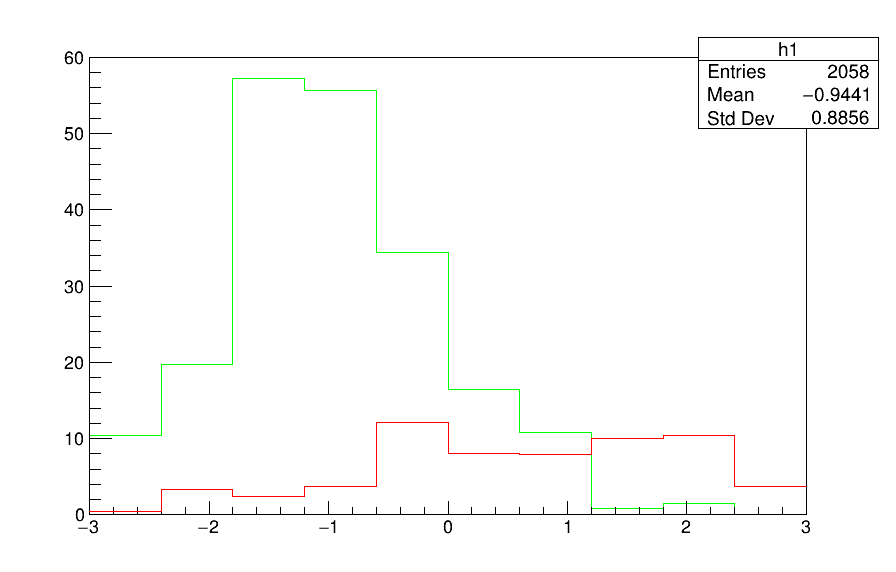

In [144]:
hist_bkg.SetLineColor(3)
hist_bkg.Draw("hist")
#gStyle.SetOptStat(0)
hist_sig.SetLineColor(2)
hist_sig.Draw('hist same')
c1.Draw()
c1.Update()

In [145]:
hist_sig.GetSum()

61.850465765804984

In [146]:
hist_bkg.GetSum()

208.3494308710433